# SHAP values (SHapley Additive exPlanations) 

#### SHAP Values is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

#### Models like decision tree could be interpret and visualize easily, but some are not (Random forest, Neural networks)

#### Shapley Values comes from cooperative game theory: The Shapley value, coined by Lloyd Shapley (1953)63, a winner Nobel Price in Economics. This is a method for assigning payouts to players depending on their contribution to the total payout. Players cooperate in a coalition and receive a certain profit from this cooperation.

#### Players? Game? Payout? What is the connection to machine learning predictions and interpretability? The “game” is the prediction task for a single instance of the dataset. The “gain” is the actual prediction for this instance minus the average prediction for all instances. The “players” are the feature values of the instance that collaborate to receive the gain (= predict a certain value).

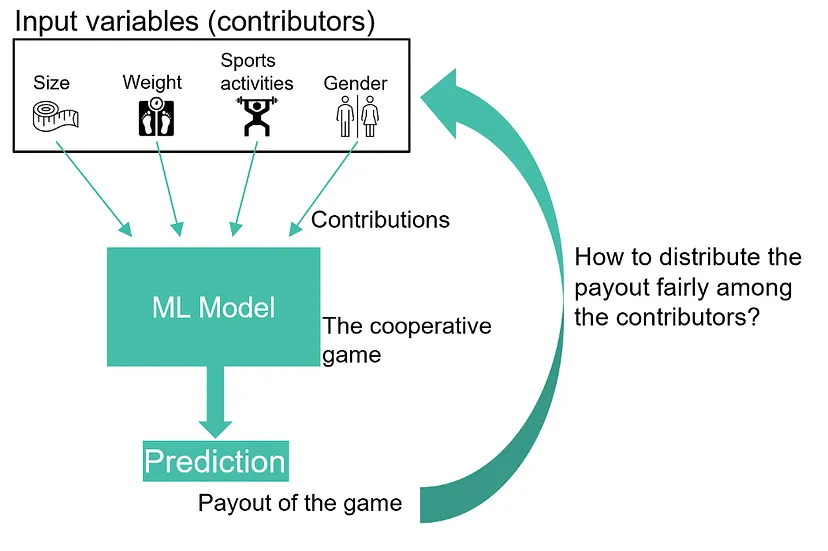

# Shapley values and SHAP values for agnostic models

#### Shapley values: are an attribution method that fairly assigns the prediction to individual features.

#### SHAP: is another computation method for Shapley values, but also proposes global interpretation methods based on combinations of Shapley values across the data (Overall model behaviour)

#### Technical definition: “average marginal contribution of a feature value over all possible coalitions.” In other words, Shapley values consider all possible predictions for an instance using all possible combinations of inputs. Because of this exhaustive approach, SHAP can guarantee properties like consistency and local accuracy.

#### Advantage: flexibility in analysing the model both locally and globally, 

#### Disadvantage: more computationally costly than other interpretation methods (Python shap package can resolve some of this problem by using approximations and optimizations, but not optimized for all types of model)

# Library

```
conda activate tf   # pandas, scikit, numpy...
canda install shap

```

In [1]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Basic Use Case (A Simple Random Forest Classifier)

#### We create a dataset with three independent variables with random values : A, B, C. The target variable is called 'A>B' and has the value true if A>B, else False.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_examples):
    """ Generate random data with columns A, B and C and target A>B. """
    A = np.random.rand(num_examples)
    B = np.random.rand(num_examples)
    C = np.random.rand(num_examples)
    target = A > B

    # Create a dataframe
    df = pd.DataFrame({'A': A, 'B': B, 'C': C, 'A>B': target})
    return df

rf_data =  generate_data(10000)


In [10]:
rf_data

,A,B,C,A>B
0,0.465974,0.041359,0.520869,True
1,0.755956,0.211744,0.930482,True
2,0.247520,0.406591,0.227566,False
3,0.165152,0.076928,0.935104,True
4,0.869289,0.808310,0.148765,True
...,...,...,...,...
9995,0.500568,0.368511,0.711618,True
9996,0.122307,0.683345,0.910932,False
9997,0.655774,0.154016,0.176830,True
9998,0.753039,0.708181,0.284754,True


#### Train a random forest classifier.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

x = rf_data.drop("A>B", axis=1)
y = rf_data['A>B']

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(x_train_rf, y_train_rf)
y_pred_rf = rf.predict(x_test_rf)
print(classification_report(y_pred_rf, y_test_rf))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1015
        True       0.99      0.99      0.99       985

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000





#### Use the _shap_ to explain the model: which attribures are the most important?
#### In principle, the explanation is model agnostic. But, for efficency, specifc type of explainer is preferred.

#### The plot shows the average (over examples in the train set) impact of attributes on the final decision.

# Difference between explainer(x) and explainer.shap_values 

#### explainer(X) returns shap._explanation.Explanation and explainer.shap_values(X) returns numpy.ndarray.
#### The numpy.ndarray is just the shap values, but the shap._explanation.Explanation contains not only the shap values, but also the base values and feature values.
#### Choose one of them based on the task ( In the example of Random Forest and CNN, we use explainer.shap_values(X). For KNN, we use explainer(X) )


In [45]:
#Binary Classification has 2 class (0 & 1)

explainer = shap.TreeExplainer(rf) # choose the type of explainer for efficiency. Default? Tree? Kernel? Gradient?
shap_values = explainer.shap_values(x_train_rf) 



'\n\nexplainer(X) returns shap._explanation.Explanation and explainer.shap_values(X) returns numpy.ndarray.\nThe numpy.ndarray is just the shap values, but the shap._explanation.Explanation contains not only the shap values, but also the base values and feature values.\nChoose one of them based on the task\n\n'

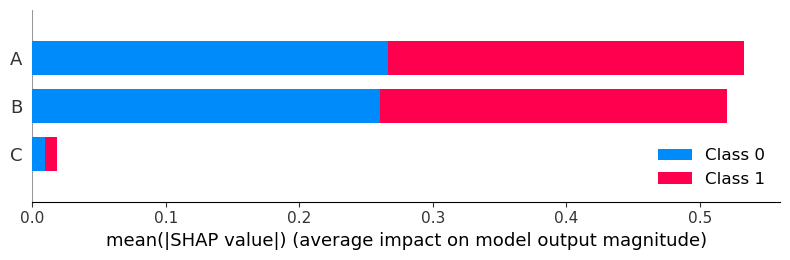

In [46]:
shap.summary_plot(shap_values, x_train_rf,  plot_type="bar", feature_names=x.columns)

## Breaking down Force Plot

#### Higher value of a feature: When a feature value is higher than its expected value (the base value), it contributes positively to the output prediction. This means that the feature's presence or higher value tends to push the model's output higher compared to the base value.

#### Lower value of a feature: Conversely, when a feature value is lower than its expected value (the base value), it contributes negatively to the output prediction. This means that the feature's absence or lower value tends to push the model's output lower compared to the base value.

#### The "longer" the feature, the more important it is.

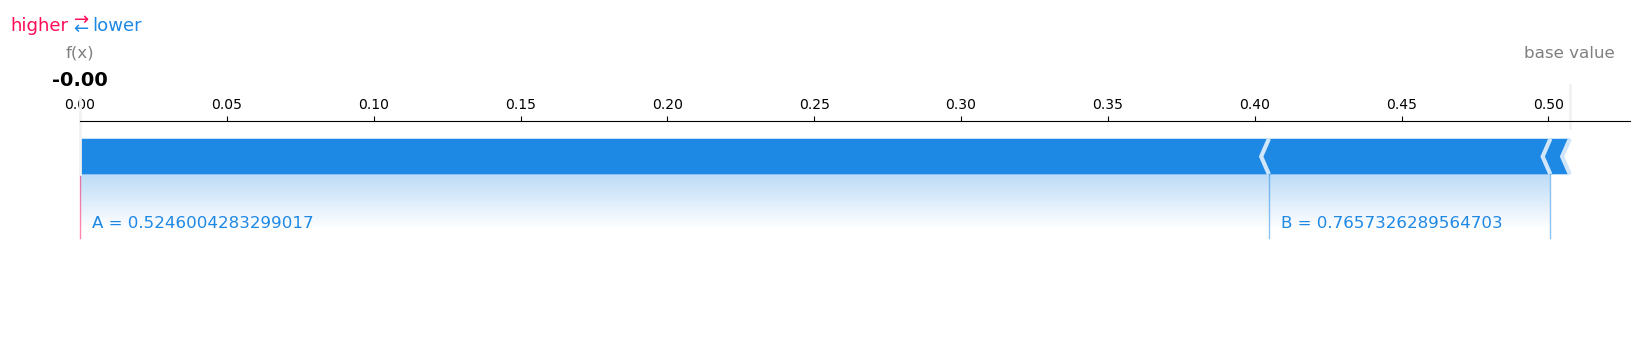

In [25]:
# force plot for local shap value

a = 0 # class 0 or 1
b = 4 # nth instance of observation classified as class 0 or 1 (as shown in a) 

# Shap vlaues for the individual predictions.
shap.plots.force(explainer.expected_value[a], shap_values[a][b,:], x.iloc[b, :], matplotlib = True, feature_names=x.columns)

# Use Case 1: KNN

#### We import California housing dataset from Scikit learn and have a look at the variables of the data.

In [14]:
import matplotlib.pyplot as plt
import time
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
california_df = pd.DataFrame(data=california.data, columns=california.feature_names)
california_df_target = pd.DataFrame(data=california.data, columns=california.feature_names)
california_df_target['median house value in $100,000 (Target)'] = california.target

display(california_df_target)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,"median house value in $100,000 (Target)"
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


#### Then, we train a KNN regressor and see how it performs using MSE

In [15]:
Xknn = california.data
yknn = california.target
Xknn_train,Xknn_test,yknn_train,yknn_test = train_test_split(Xknn, yknn, test_size=0.2, random_state=0)

# K Nearest Neighbor
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=8)
knn.fit(Xknn_train, yknn_train)
yknn_pred = knn.predict(Xknn_test)



In [30]:
from sklearn.metrics import mean_squared_error

# Predict on the test set
yknn_pred = knn.predict(Xknn_test)

# Evaluate the performance using mean squared error (MSE)
mse = mean_squared_error(yknn_test, yknn_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.0892545840494126


#### Now we try to use shap explainer to find out the relative importance of each feature. We use KernelExplainer for KNN. 

In [16]:
# Create the SHAP Explainers
# SHAP has the following explainers: deep, gradient, kernel, linear, tree, sampling
# Must use Kernel method on knn
# Summarizing the data with k-Means is a trick to speed up the processing

"""
Rather than use the whole training set to estimate expected values, we summarize with a set of weighted kmeans,each weighted by the number of points they represent. 
In the Boston housing example form the literature, running without kmeans took 1 hr 6 mins 7 sec.Running with kmeans took 2 min 47 sec. 
Boston Housing is a small dataset.Running SHAP on models that require the Kernel method becomes prohibitive.
"""

# build the kmeans summary
Xknn_train_summary = shap.kmeans(Xknn_train, 10)

explainerKNN = shap.KernelExplainer(knn.predict,Xknn_train_summary)
shap_values_KNN_test = explainerKNN(Xknn_test)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\Wan Hok Ming\miniconda3\envs\tf\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
100%|██████████| 4128/4128 [00:59<00:00, 69.76it/s]


# Breaking down Beeswarm plot

#### The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature

#### Here, we plot a beeswarplot and a bar chart to viusalize the average (over examples in the train set) impact of attributes on the final decision of the KNN Regressor

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


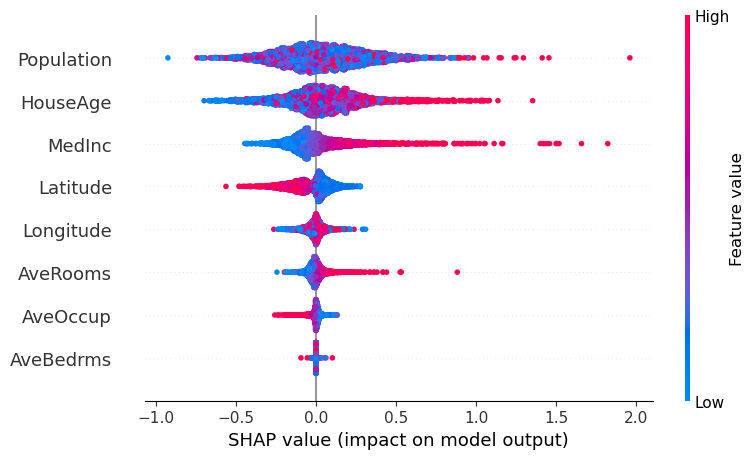

In [17]:
shap.summary_plot(shap_values_KNN_test, Xknn_test, feature_names=california.feature_names)

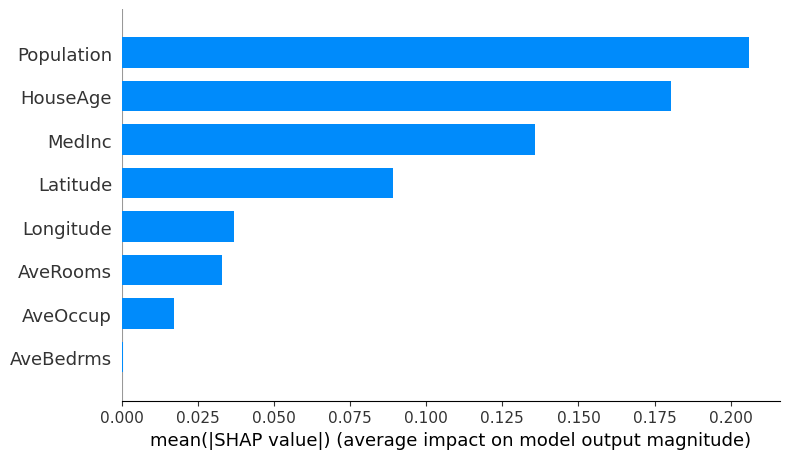

In [22]:
shap.summary_plot(shap_values_KNN_test, Xknn_test, feature_names=california.feature_names, plot_type="bar")

#### Plot Force plot for each instance

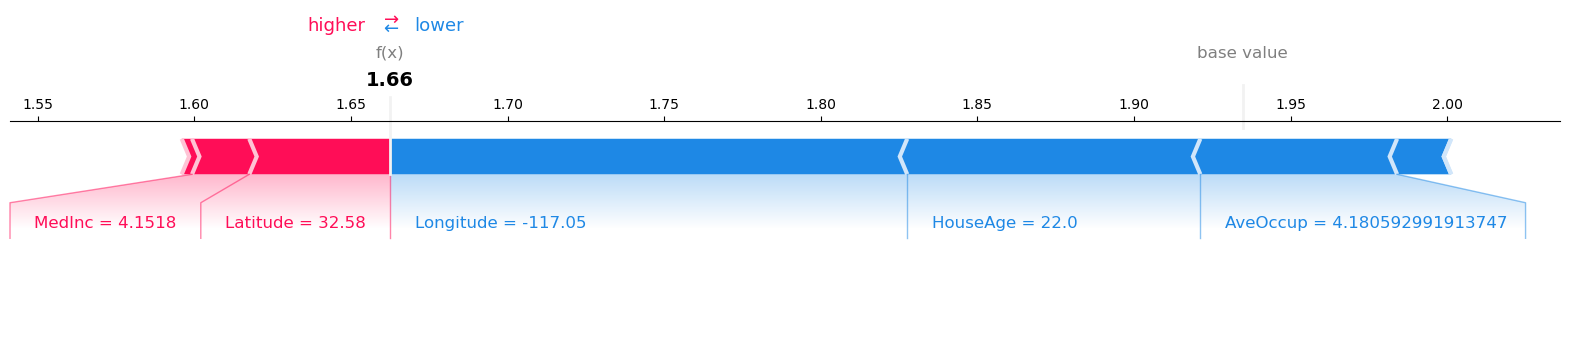

In [25]:
# Force plot for interpreting local importance of different features

j = 0

shap.plots.force(explainerKNN.expected_value, shap_values_KNN_test.values[j], Xknn_test[j], matplotlib= True, feature_names=california.feature_names)

# The result of Random Forest Classifier on the Same dataset demonstrated in the project literature 

 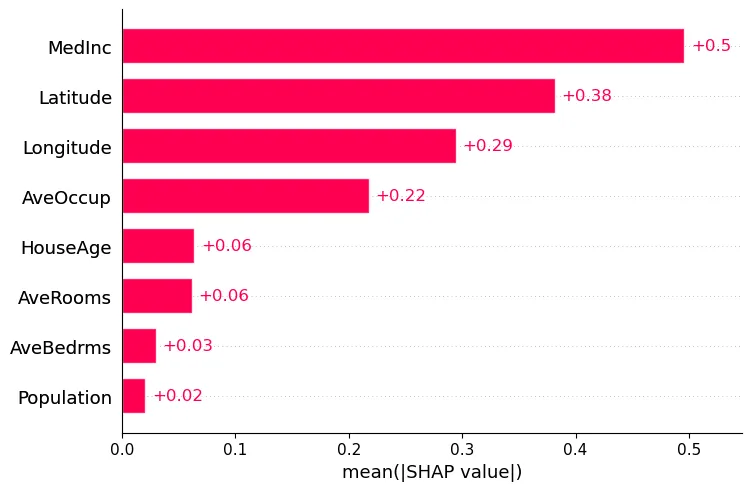

# Use Case 2: Convolution Nerual Networks (MNIST)

#### We import Keras package to get the MNIST dataset and train the convolution neural network for classifing hand written digits

In [4]:
""" ---------------------------------------------------------------"""
"""          Neural networks 2 - Convolutinal NN small             """
""" ---------------------------------------------------------------"""
"""https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/"""


import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

import time


# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to be [samples][width][height][pixels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],  28, 28, 1).astype('float32')

# train-validation split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_validation = X_validation / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_validation = np_utils.to_categorical(y_validation)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]


def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# initialize the model
model = baseline_model()

# Fit the model
#time the model
start = time.time()
model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=200, verbose=2)
end = time.time()
print("Training time:", end-start, "seconds")

# summarize the model's internal workings
model.summary()

# visualize the model (requires pydot and graphviz)
# plot_model(model, to_file='model_architecture_cnn1.png', show_shapes=True, show_layer_names=True)

# Final evaluation of the model
print("Final evaluation of the model")
scores = model.evaluate(X_test, y_test, verbose=1)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
270/270 - 4s - loss: 0.2687 - accuracy: 0.9224 - val_loss: 0.0921 - val_accuracy: 0.9743 - 4s/epoch - 14ms/step
Epoch 2/10
270/270 - 3s - loss: 0.0823 - accuracy: 0.9752 - val_loss: 0.0596 - val_accuracy: 0.9818 - 3s/epoch - 13ms/step
Epoch 3/10
270/270 - 3s - loss: 0.0585 - accuracy: 0.9826 - val_loss: 0.0485 - val_accuracy: 0.9860 - 3s/epoch - 13ms/step
Epoch 4/10
270/270 - 4s - loss: 0.0462 - accuracy: 0.9857 - val_loss: 0.0475 - val_accuracy: 0.9873 - 4s/epoch - 13ms/step
Epoch 5/10
270/270 - 3s - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.0444 - val_accuracy: 0.9875 - 3s/epoch - 13ms/step
Epoch 6/10
270/270 - 3s - loss: 0.0317 - accuracy: 0.9896 - val_loss: 0.0451 - val_accuracy: 0.9887 - 3s/epoch - 12ms/step
Epoch 7/10
270/270 - 4s - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0396 - val_accuracy: 0.9888 - 4s/epoch - 13ms/step
Epoch 8/10
270/270 - 4s - loss: 0.0208 - accuracy: 0.9934 - val_loss: 0.0412 - val_accuracy: 0.9897 - 4s/epoch - 13ms/step
Epoch 9/10
270/2


#### We use GradientExplainer in this case

In [40]:
# since we have two inputs we pass a list of inputs to the explainer
explainer_tf = shap.GradientExplainer(model, X_train)

# we explain the model's predictions on the first three samples of the test set
shap_values_tf = explainer_tf.shap_values(X_train[0:3])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [42]:
# since the model has 10 outputs we get a list of 10 explanations (one for each output)
print(len(shap_values_tf))

10


In [43]:
# since the model has 2 inputs we get a list of 2 explanations (one for each input) for each output
print(len(shap_values_tf[0]))

3


#### We plot the interpretation result using image_plot from the shap package. This plot is deisgned for image classification

#### The dots are the pixels (features) that contributes to the classification

#### We have 10 epoches in total. Each epoch has different results, they could be averaged and get the overall impact of each feature 

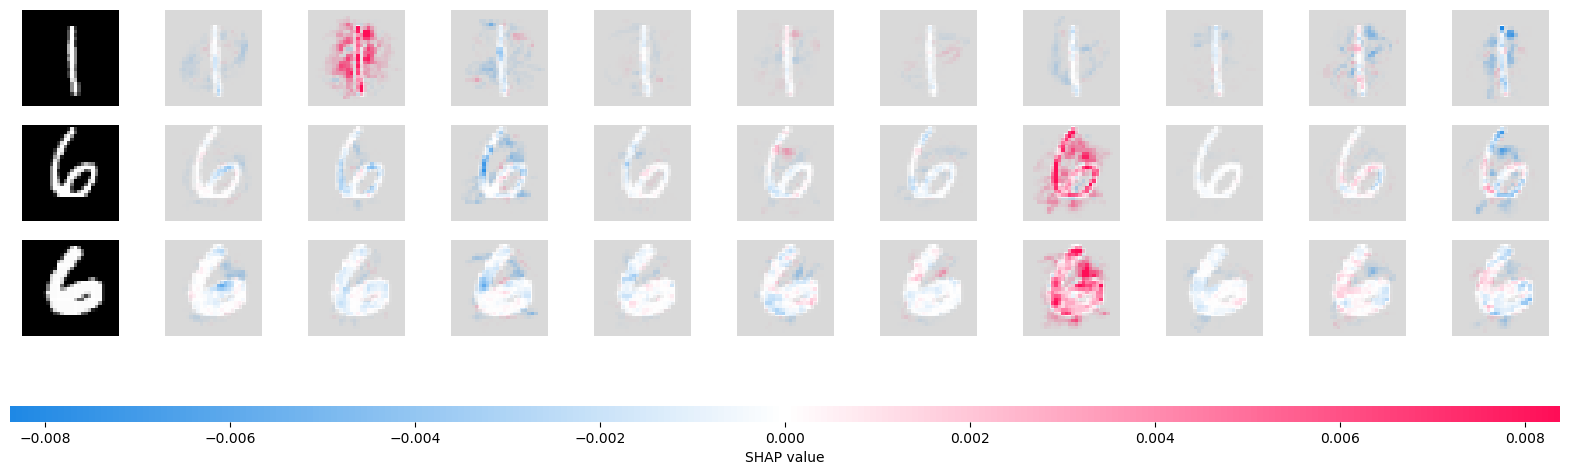

In [44]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values_tf[i] for i in range(10)], X_train[:3])

#shap.image_plot(shap_values, pixel_values=None, labels=None, width=20, aspect=0.2, hspace=0.2, labelpad=None, show=True)

# Summary

#### Shapley Values is a powerful tool for interpreting various models that works in a black box. It is inspired by cooperative game theory

#### It is consistent, accurate, can provide interpretation both globally and locally. However, it could be computationally costly

#### To reduce the computational cost, various techniques could be employed (choosing the appropriate type of explainer, running k-means (KNN example)) 

# References

Using SHAP Values to Explain How Your Machine Learning Model Works
https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learningmodel-works-732b3f40e137

SHAP and LIME Python Libraries: Part 1 - Great Explainers, with Pros and Cons to Both
https://domino.ai/blog/shap-lime-python-libraries-part-1-great-explainers-pros-cons

Molnar, C. (2020). Interpretable machine learning. Lulu. com. Chapter 9 Local Model-Agnostic
Methods
https://christophm.github.io/interpretable-ml-book/local-methods.html

What is the Shapley value ?
https://medium.com/the-modern-scientist/what-is-the-shapley-value-8ca624274d5a

An Introduction to SHAP Values and Machine Learning Interpretability
https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

Welcome to the SHAP documentation
https://shap.readthedocs.io/en/latest/

DM_course: Hands on scikit-learn in python
http://source.ijs.si/pkraljnovak/DM_course